In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys


sys.path.insert(1, "./../util")
sys.path.insert(1, "./../model")
from encoded_protein_dataset_new import get_embedding, EncodedProteinDataset_new, EncodedProteinDataset_aux, collate_fn_new#, dynamic_collate_fn
from pseudolikelihood import get_npll2, get_npll_indep, get_npll, get_npll3
import torch, torchvision
from torch.nn.utils import clip_grad_norm_
from potts_decoder import PottsDecoder
from torch.utils.data import DataLoader, RandomSampler
from functools import partial
import biotite.structure
from biotite.structure.io import pdbx, pdb
from biotite.structure.residues import get_residues
from biotite.structure import filter_backbone
from biotite.structure import get_chains
from biotite.sequence import ProteinSequence
from typing import Sequence, Tuple, List
import scipy
from tqdm import tqdm
import pandas as pd
import csv
import time
from torch.utils.tensorboard import SummaryWriter

#import pytorch_warmup as warmup
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR

##TURIN HPC
#sys.path.insert(1, "/Data/silva/esm/")

## EUROPA
#sys.path.insert(1, "/home/lucasilva/esm/")

##Lucas computer
sys.path.insert(1, "/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/esm/")
import esm
#from esm.inverse_folding import util
import esm.pretrained as pretrained
from ioutils import read_fasta, read_encodings
from torch.nn.utils.rnn import pad_sequence
from collections import defaultdict
from Bio import SeqIO
from dynamic_loader import dynamic_collate_fn, dynamic_cluster

from torch.nn.functional import softmax
from torch.distributions import Categorical


In [2]:
### IDEA: MSAS PROCEDURE CAN GIVE DIFFERENT OUTPUT SHAPES? ASK
max_msas = 1
#msa_dir = "/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/msas/"
msa_dir = "/home/luchinoprince/split2/"
encoding_dir ="/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/structure_encodings"

train_dataset = EncodedProteinDataset_aux(os.path.join(msa_dir, 'train'), encoding_dir, noise=0.02, max_msas=max_msas)          ## Default value of noise used


batch_structure_size = 1   ### I think with empty GPU we can go up to 16 easily
perc_subset_test = 1.0     ## During the training, for every dataset available we select a random 10% of its samples
batch_msa_size = 128 ### old is 32, original is 16
q = 21 ##isn't always 21
#dynamic_collate_fn

collate_fn = partial(dynamic_collate_fn, q=q, batch_size=batch_structure_size, batch_msa_size=batch_msa_size)
train_loader = DataLoader(train_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=True,
num_workers=1, pin_memory=True)




/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/Inverse_Folding/tests/./../util/encoded_protein_dataset_new.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encodings = torch.tensor(read_encodings(encoding_path, trim=False))


In [3]:
train_dataset[0][0].shape

/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/Inverse_Folding/tests/./../util/encoded_protein_dataset_new.py:187: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encodings = torch.tensor(read_encodings(encoding_path, trim=False))


torch.Size([9894, 119])

In [5]:
decoder = None
embedding = None
torch.cuda.empty_cache()

seed = 24877
torch.random.manual_seed(seed)
np.random.seed(seed)



update_steps = 500                                   ##Usual values are update steps=10^5, test_steps=10^2
bk_iter = False                                                  ## This tells us how ofter we save a model(default values is every ten-thousand updates)
#n_epochs = update_steps//(len(train_dataset)//batch_structure_size)   ## the other update steps will be used for "partial epochs", I want to save the last complet epoch
#print(f"With update_steps:{update_steps} we will do {n_epochs} full epochs")

input_encoding_dim = 512
param_embed_dim = 512
n_param_heads = 32
d_model = 512 ##old 512
n_heads = 8 ## old 8
n_layers = 6
## Check before running which is the GPU which is free the most and put it as the running device
device = 0        ## DON'T SET TO ONE OTHER THAN IN SPECIAL SPECIAL OCCASIONS, VERY NOISYYYYY!
dropout = 0.1

decoder = PottsDecoder(q, n_layers, d_model, input_encoding_dim, param_embed_dim, n_heads, n_param_heads, dropout=dropout)
decoder.to(device)
embedding = get_embedding(q)
embedding.to(device)

Embedding(22, 21)

In [6]:
def get_loss_ardca(decoder, inputs, eta_J, eta_h):
    """eta is the multiplicative term in front of the penalized negative pseudo-log-likelihood"""
    msas, encodings, padding_mask  = [input.to(device) for input in inputs]
    B, M, N = msas.shape
    #print(f"encodings' shape{encodings.shape}, padding mask:{padding_mask.shape}")
    couplings, fields = decoder.forward_ardca(encodings, padding_mask)
    # embed and reshape to (B, M, N*q)
    msas_embedded = embedding(msas).view(B, M, -1)

    # get npll
    npll3 = get_npll3(msas_embedded, couplings, fields, N, q)
    padding_mask_inv = (~padding_mask)

    # multiply with the padding mask to filter non-existing residues (this is probably not necessary)       
    #npll = npll * padding_mask_inv.unsqueeze(1)
    ####### CHANGE OF BARTH TO SOLVE BUG OF ARDCA TRAINING!! #################
    #print(npll3.shape)
    npll3 = npll3.reshape((B,M,-1)) * padding_mask_inv.unsqueeze(1)
    penalty = eta_J*(torch.sum(couplings**2))/B + eta_h*(torch.sum(fields**2))/B

    # the padding mask does not contain the msa dimension so we need to multiply by M
    npll_mean = torch.sum(npll3) / (M * torch.sum(padding_mask_inv))
    loss_penalty = npll_mean + penalty
    return loss_penalty, npll_mean.item() 


def get_loss_loader_ardca(decoder, loader, eta_J, eta_h):
    decoder.eval()
    losses = []
    #with torch.no_grad():
    for effective_batch_size, inputs_packed in loader:
        npll_full = 0
        for inputs in inputs_packed:
            mini_batch_size = inputs[0].shape[0]
            #_, npll = get_loss_indep(decoder, inputs, eta_J, eta_h) ## For independent model without couplings
            _, npll = get_loss_ardca(decoder, inputs, eta_J, eta_h)
            npll_full += npll*mini_batch_size/effective_batch_size
        losses.append(npll_full)
            #del inputs
    
    return np.mean(losses)

def train_ardca(decoder, inputs_packed, eta_J, eta_h, optimizer, scaler):
    effective_batch_size = inputs_packed[0]
    loss_penalty_full = 0
    train_loss_full = 0
    optimizer.zero_grad(set_to_none=True)                           ## set previous gradients to 0
    with torch.cuda.amp.autocast():  ## autocasting mixed precision
        for inputs in inputs_packed[1]:
            mini_batch_size = inputs[0].shape[0]
            #loss_penalty, train_batch_loss = get_loss_indep(decoder, inputs, eta_J, eta_h)    ## get the current loss for the batch this is for the independent training
            loss_penalty, train_batch_loss = get_loss_ardca(decoder, inputs, eta_J, eta_h)
            loss_penalty = loss_penalty * mini_batch_size/effective_batch_size
            train_batch_loss = train_batch_loss * mini_batch_size/effective_batch_size
            #loss_penalty.backward()                         ## Get gradients
            scaler.scale(loss_penalty).backward()
            loss_penalty_full += loss_penalty.detach()
            train_loss_full += train_batch_loss
    
    
    scaler.step(optimizer)
    scaler.update()
    #optimizer.step()   

    return loss_penalty_full, train_loss_full

def train_ardca2(decoder, inputs_packed, eta_J, eta_h, optimizer, scaler):
    """This training without mixed precision and autocast"""
    effective_batch_size = inputs_packed[0]
    loss_penalty_full = 0
    train_loss_full = 0
    optimizer.zero_grad(set_to_none=True)                           ## set previous gradients to 0
    for inputs in inputs_packed[1]:
        mini_batch_size = inputs[0].shape[0]
        loss_penalty, train_batch_loss = get_loss_ardca(decoder, inputs, eta_J, eta_h)
        loss_penalty = loss_penalty * mini_batch_size/effective_batch_size
        train_batch_loss = train_batch_loss * mini_batch_size/effective_batch_size
        loss_penalty.backward()                         ## Get gradients
        loss_penalty_full += loss_penalty.detach()
        train_loss_full += train_batch_loss
        
    optimizer.step()   

    return loss_penalty_full, train_loss_full

In [7]:
## Let us also save the hyperparameters
#with summary_writer as w:
import warnings
warnings.filterwarnings("ignore")
lr = 1e-4
optimizer = torch.optim.AdamW(decoder.parameters(), lr=lr)
eta_J = 0.0
eta_h = 0.0

start = time.time()
scaler = torch.cuda.amp.GradScaler()
with tqdm(total = update_steps) as pbar: ##This is used to have the nice loading bar while training
    train_loss = 0
    update_step = 0
    max_gpu=0
    train_batch_losses = []
    train_batch_losses_penalty = []
    epoch = 0.0
    while update_step < update_steps:
        for inputs_packed in train_loader:
            decoder.train()

            loss_penalty, train_batch_loss = train_ardca2(decoder, inputs_packed, eta_J, eta_h, optimizer, scaler)
            loss_penalty.detach()
            #optimizer.step()                                ## Do a step of GD
            update_step += 1                                ## Increase update step (the update steps will count also different batches within the same epoch)
            epoch = update_step / len(train_loader)
            
            train_batch_losses.append(train_batch_loss) ## Here we append the lossess in the different batches within the same epoch
            train_batch_losses_penalty.append(loss_penalty.item())

        
            pbar.set_description(f'update_step: {update_step}, epoch: {epoch:.2f}  train: {train_loss:.2f}')
            pbar.update(1)
            
print(f"It took {time.time()-start} seconds")


update_step: 500, epoch: 500.00  train: 0.00: 100%|██████████| 500/500 [00:27<00:00, 17.96it/s]

It took 27.84272313117981 seconds


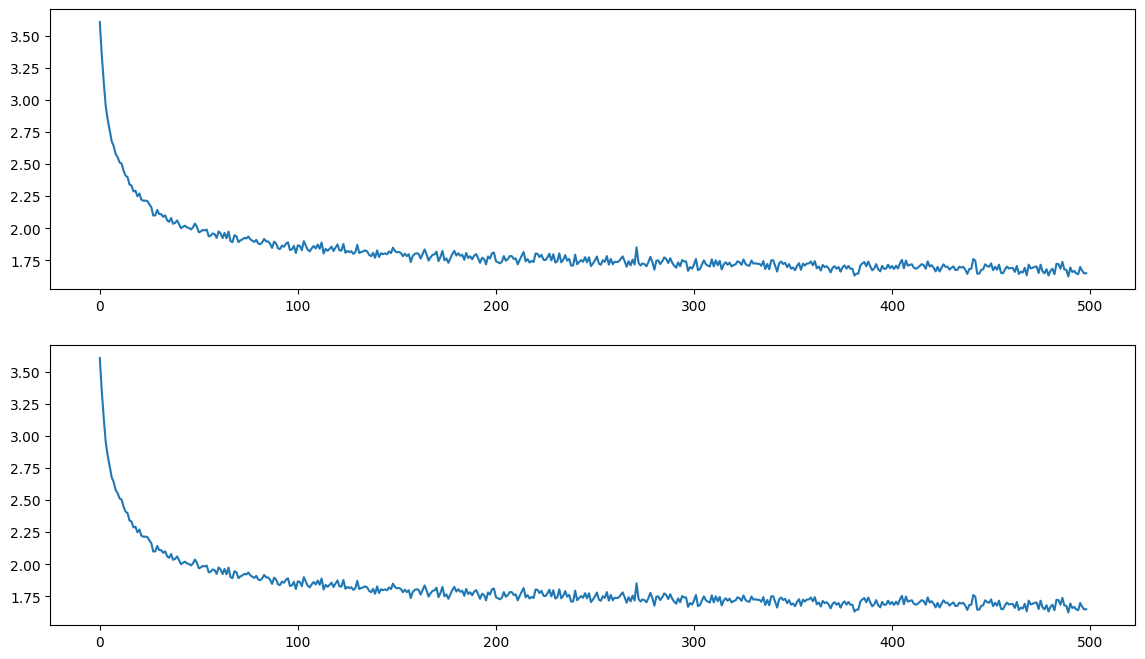

In [8]:
fig, [ax1,ax2] = plt.subplots(nrows=2, ncols=1, figsize=(14,8))
ax1.plot(train_batch_losses[1:1000])
ax2.plot(train_batch_losses_penalty[1:1000])

In [9]:
train_dataset.msas_paths

['/home/luchinoprince/split2/train/4x28C01_train.a3m.pt']

In [10]:
train_msa=torch.load(train_dataset.msas_paths[0]).to(torch.int)
train_msa

tensor([[20,  4,  7,  ..., 20, 20, 20],
        [ 2,  4,  0,  ..., 20, 20, 20],
        [20,  4, 17,  ..., 20, 20, 20],
        ...,
        [20, 20, 20,  ..., 20, 20, 20],
        [20, 20, 20,  ..., 20, 20, 20],
        [20, 20, 20,  ..., 15, 14,  7]], dtype=torch.int32)

In [11]:
decoder.eval()

for inputs_packed in train_loader:
    for inputs in inputs_packed[1]:
        msas, encodings, padding_mask  = [input.to(device, non_blocking=True) for input in inputs]
        B, M, N = msas.shape
        #print(f"encodings' shape{encodings.shape}, padding mask:{padding_mask.shape}")
        couplings, fields = decoder.forward_ardca(encodings, padding_mask)


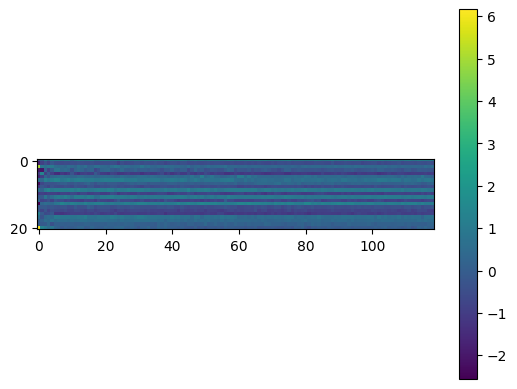

In [12]:
#fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6,18))
plt.imshow(np.transpose(fields.reshape(N,q).cpu().detach().numpy()))
plt.colorbar()


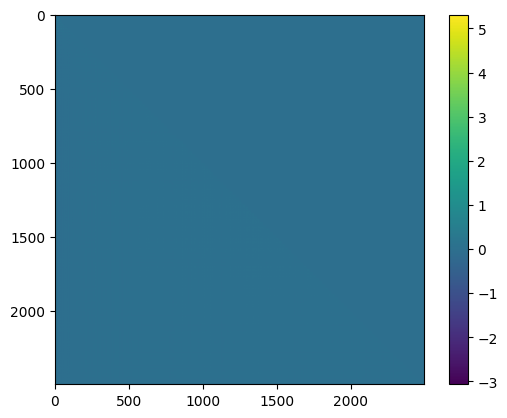

In [13]:
plt.imshow(couplings[0,:,:].cpu().detach().numpy())
plt.colorbar()

In [14]:
couplings.max()

tensor(5.3125, device='cuda:0', grad_fn=<MaxBackward1>)

In [15]:
fields[0, 1:5]

tensor([-1.8851,  5.0591, -2.0118, -0.9108], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [16]:
def compute_covariance(msa, q):
    """
    Compute covariance matrix of a given MSA having q different amino acids
    """
    M, N = msa.shape

    # One hot encode classes and reshape to create data matrix
    D = torch.flatten(one_hot(msa, num_classes=q), start_dim=1).to(torch.float32)

    # Remove one amino acid
    D = D.view(M, N, q)[:, :, :q-1].flatten(1)

    # Compute bivariate frequencies
    bivariate_freqs = D.T @ D / M
    
    # Compute product of univariate frequencies
    univariate_freqs = torch.diagonal(bivariate_freqs).view(N*(q-1), 1) @ torch.diagonal(bivariate_freqs).view(1, N*(q-1))

    return bivariate_freqs - univariate_freqs

In [17]:
#### OLD SAMPLER, VERY SLOW ########
#with torch.no_grad():
#    samples_ardca = decoder.sample_ardca(encodings, padding_mask, n_samples=4000)

samples_ardca = decoder.sample_ardca_full(encodings, padding_mask, device='cpu', n_samples=10000)

In [18]:
samples_ardca.device

device(type='cpu')

In [19]:
from torch.nn.functional import one_hot
samples_ardca=torch.tensor(samples_ardca, dtype=torch.long)
train_msa2 = torch.tensor(train_msa, dtype=torch.long)
cov_train = compute_covariance(train_msa2, q)
cov_ardca = compute_covariance(samples_ardca, q)

scipy.stats.pearsonr(cov_train.flatten(), cov_ardca.flatten())

PearsonRResult(statistic=0.8834451649136882, pvalue=0.0)

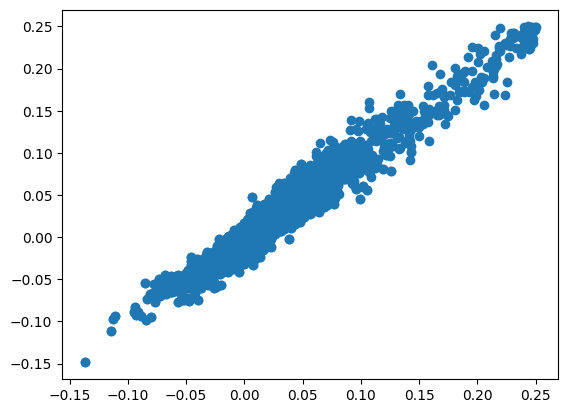

In [20]:
plt.scatter(cov_ardca.flatten(), cov_train.flatten())

In [21]:
samples_ardca

tensor([[20, 20, 20,  ..., 15, 15,  7],
        [20, 20, 20,  ..., 20, 20, 20],
        [20,  4, 20,  ...,  3, 20, 20],
        ...,
        [20, 20, 20,  ...,  3,  8, 20],
        [20, 20, 20,  ...,  3, 14, 20],
        [20, 20, 20,  ..., 15, 20, 20]])

In [22]:
q=21
def get_embedding(q):

    embedding = torch.nn.Embedding(q+1, q).requires_grad_(False)
    embedding.weight.data.zero_()

    embedding.weight[:q, :q] = torch.eye(q)

    return embedding
embeddings = get_embedding(q)

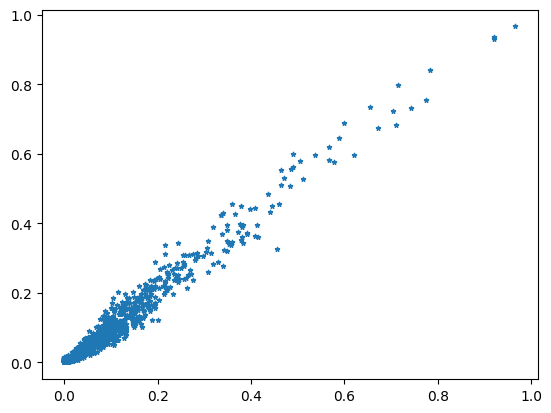

In [23]:
M,N = train_msa.shape 
M_potts = samples_ardca.shape[0]
fi_potts = torch.sum(embeddings(samples_ardca), dim=0)/M_potts
msa_true_emb = embeddings(train_msa)
fi_true=torch.sum(msa_true_emb, dim=0)/M
plt.scatter(fi_true.flatten(), fi_potts.flatten(), marker="*", s=10)

#### Now let us test a trained model on a train and then test sequence.

In [24]:
device='cpu'
## This would work on windows
#bk_dir= 'D:/Data/InverseFolding/Intermediate_Models/'

bk_dir = "/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Intermediate_Models/"
fname_par = 'model_11_07_2023_epoch_' + str(94.0) + '_ardca' + '.pt'
#fname_par = "model_20_01_2023_epoch_1000.0.pt"
checkpoint = torch.load(os.path.join(bk_dir, fname_par))


q=21
args = checkpoint['args_run']
n_layers = args['n_layers']
param_embed_dim = d_model = args['param_embed_dim']
input_encoding_dim = args['input_encoding_dim']
n_heads=args['n_heads']
n_param_heads=args['n_param_heads']
dropout=args['dropout']

decoder = PottsDecoder(q, n_layers, d_model, input_encoding_dim, param_embed_dim, n_heads, n_param_heads, dropout=dropout);
decoder.to(device);

decoder.load_state_dict(checkpoint['model_state_dict']);
decoder.eval();   ##to generate data we need just the forward pass of the model!

In [25]:
for inputs_packed in train_loader:
    for inputs in inputs_packed[1]:
        msas, encodings, padding_mask  = [input.to(device, non_blocking=True) for input in inputs]
        B, M, N = msas.shape
        #print(f"encodings' shape{encodings.shape}, padding mask:{padding_mask.shape}")
        couplings, fields = decoder.forward_ardca(encodings, padding_mask)

In [26]:
#################### OLD SAMPLER, ITS VERY SLOW ######################
#with torch.no_grad():
#    samples_ardca = decoder.sample_ardca(encodings, padding_mask, n_samples=100)

In [26]:
samples_ardca = decoder.sample_ardca_full(encodings, padding_mask, n_samples=10000)

In [27]:
from torch.nn.functional import one_hot
samples_ardca=torch.tensor(samples_ardca, dtype=torch.long)
train_msa2 = torch.tensor(train_msa, dtype=torch.long)
cov_train = compute_covariance(train_msa2, q)
cov_ardca = compute_covariance(samples_ardca, q)

scipy.stats.pearsonr(cov_train.flatten(), cov_ardca.flatten())

PearsonRResult(statistic=0.6781620258275178, pvalue=0.0)

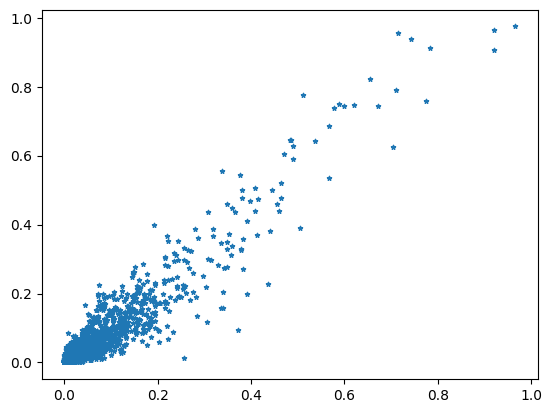

In [28]:
M,N = train_msa.shape 
M_potts = samples_ardca.shape[0]
fi_potts = torch.sum(embeddings(samples_ardca), dim=0)/M_potts
msa_true_emb = embeddings(train_msa)
fi_true=torch.sum(msa_true_emb, dim=0)/M
plt.scatter(fi_true.flatten(), fi_potts.flatten(), marker="*", s=10)

#### Ok now let us move to something in the superfamily test dataset which is the thoughest

In [29]:
max_msas = 1
msa_dir = "/home/luchinoprince/split2/"
encoding_dir ="/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/structure_encodings/"

superfamily_test_dataset = EncodedProteinDataset_aux(os.path.join(msa_dir, 'test/superfamily'), encoding_dir, noise=0.0, max_msas=max_msas)
batch_structure_size_train = 1### I think with empty GPU we can go up to 16 easily
batch_structure_size=1
perc_subset_test = 1.0     ## During the training, for every dataset available we select a random 10% of its samples
batch_msa_size = 128 ### old is 32, original is 16
q = 21 ##isn't always 21
#dynamic_collate_fn

collate_fn = partial(dynamic_collate_fn, q=q, batch_size=batch_structure_size, batch_msa_size=batch_msa_size)

superfamily_test_loader = DataLoader(superfamily_test_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=False, 
num_workers=4, pin_memory=True, sampler=RandomSampler(superfamily_test_dataset, replacement=True, num_samples=int(perc_subset_test*len(superfamily_test_dataset))))

In [30]:
superfamily_test_dataset.msas_paths

['/home/luchinoprince/split2/test/superfamily/3q7hA00.a3m.pt']

In [31]:
test_msa=torch.load(superfamily_test_dataset.msas_paths[0]).to(torch.int)
test_msa.shape

torch.Size([7994, 180])

In [32]:
for inputs_packed in superfamily_test_loader:
    for inputs in inputs_packed[1]:
        msas, encodings, padding_mask  = [input.to(device, non_blocking=True) for input in inputs]
        B, M, N = msas.shape
        #print(f"encodings' shape{encodings.shape}, padding mask:{padding_mask.shape}")
        couplings, fields = decoder.forward_ardca(encodings, padding_mask)

In [33]:
############# OLD SAMPLER, SLOW! ###############
#with torch.no_grad():
#    samples_ardca_test = decoder.sample_ardca(encodings, padding_mask, n_samples=1000)
samples_ardca_test = decoder.sample_ardca_full(encodings, padding_mask, device=0, n_samples=10000)

In [34]:
from torch.nn.functional import one_hot
samples_ardca_test=torch.tensor(samples_ardca_test.to('cpu'), dtype=torch.long)
test_msa = torch.tensor(test_msa, dtype=torch.long)
cov_test = compute_covariance(test_msa, q)
cov_ardca_test = compute_covariance(samples_ardca_test, q)

res=scipy.stats.pearsonr(cov_test.flatten(), cov_ardca_test.flatten())
res

PearsonRResult(statistic=0.3921982118435956, pvalue=0.0)

In [19]:
res[0]

0.3918040434191982

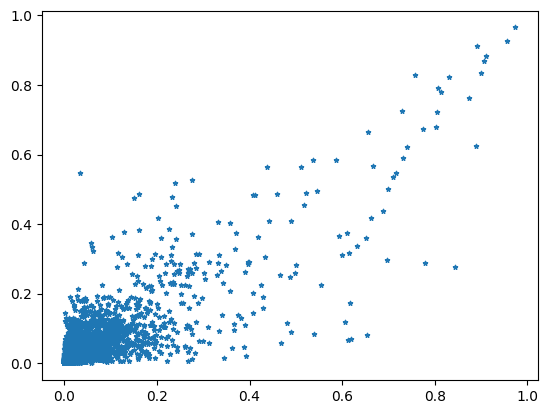

In [35]:
M,N = test_msa.shape 
M_ardca = samples_ardca_test.shape[0]
fi_ardca = torch.sum(embeddings(samples_ardca_test), dim=0)/M_ardca
msa_true_emb = embeddings(test_msa)
fi_true=torch.sum(msa_true_emb, dim=0)/M
plt.scatter(fi_true.flatten(), fi_ardca.flatten(), marker="*", s=10)

## Let us try to speed up the sampler (OLD CODE, NOW IT IS IN THE MODULE)

In [38]:
with torch.no_grad():
    device = 0
    ############# MOVE EVERYTHING TO CORRECT DEVICE #######
    decoder = decoder.to(device)
    encodings = encodings.to(device)
    padding_mask = padding_mask.to(device)
    n_samples = 8000
    B, N, _ = encodings.shape
    samples = torch.zeros(n_samples, N, dtype=torch.int).to(device)
    decoder.eval()
    q = decoder.q
    ## fields shape: (B,N,q), we will consider B=1 for the moment
    ## Couplings shape: (B, N*q, N*q)
    couplings, fields = decoder.forward_ardca(encodings, padding_mask)

    ## At the moment move to CPU! Then maybe move to GPU if we are able to vectorize
    couplings = couplings
    fields = fields
    ##############################################################################

    fields = fields[0,:].reshape(N, q)
    #p_pos = softmax(-fields[0], dim=0)
    p_pos = softmax(fields[0], dim=0)

    samples[:,0] = Categorical(p_pos).sample((n_samples,))
    #samples[1,0] = 12
    #Ham = torch.zeros(n_samples, q)
    couplings = couplings[0, :, :] #### This simplifies


    for pos in range(1,N):
        #print(pos)
        Ham = torch.zeros(n_samples, q).to(device)
        Ham += fields[pos, :]
        for acc in range(pos):
            ### Can we also vectorize this? Not sure it is going to help that much
            for aa in range(q):
                second_idx = acc*q + samples[:, acc]
                Ham[:, aa] += couplings[pos*q+aa, second_idx]#.unsqueeze(-1)
        p_pos = softmax(Ham, dim=1)
        samples[:, pos] = Categorical(p_pos).sample()


In [68]:
samples.device

device(type='cpu')

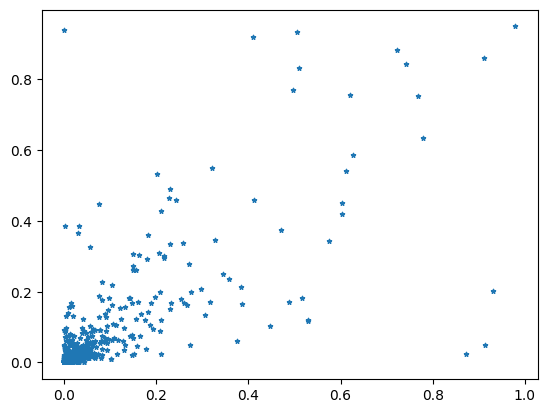

In [66]:
embeddings=get_embedding(q)
M,N = test_msa.shape 
M_ardca = samples.shape[0]
fi_ardca = torch.sum(embeddings(samples), dim=0)/M_ardca
msa_true_emb = embeddings(test_msa)
fi_true=torch.sum(msa_true_emb, dim=0)/M
plt.scatter(fi_true.flatten(), fi_ardca.flatten(), marker="*", s=10)

In [58]:
samples=torch.tensor(samples, dtype=torch.long)
test_msa = torch.tensor(test_msa, dtype=torch.long)
cov_test = compute_covariance(test_msa, q)
cov_ardca_test = compute_covariance(samples, q)

scipy.stats.pearsonr(cov_test.flatten(), cov_ardca_test.flatten())

/tmp/ipykernel_198477/1719031071.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  samples=torch.tensor(samples, dtype=torch.long)
/tmp/ipykernel_198477/1719031071.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_msa = torch.tensor(test_msa, dtype=torch.long)


PearsonRResult(statistic=0.7292639861554439, pvalue=0.0)